<a href="https://colab.research.google.com/github/Harshithaprudhivi/Team-15-project/blob/main/ECG_Synthesizer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wfdb neurokit2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 708.4/708.4 kB 32.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 98.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.1 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.1 which is incompatible.


In [ ]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import wfdb, neurokit2 as nk
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, TimeDistributed, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import os

# New section

In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
import os
import wfdb
import numpy as np

def convert_all_wfdb_dirs(base_input_dirs, base_output_root):
    for input_dir in base_input_dirs:
        rel_dir_name = os.path.basename(input_dir.rstrip('/'))
        output_dir = os.path.join(base_output_root, f'npy_{rel_dir_name}')
        os.makedirs(output_dir, exist_ok=True)

        for root, _, files in os.walk(input_dir, topdown=True, followlinks=False):
            for file in files:
                if file.endswith('.hea'):
                    record_path = os.path.join(root, file[:-4])
                    rel_path = os.path.relpath(record_path, input_dir)
                    save_path = os.path.join(output_dir, f'{rel_path}.npy')

                    os.makedirs(os.path.dirname(save_path), exist_ok=True)

                    try:
                        print(f"Reading: {record_path}")
                        record = wfdb.rdrecord(record_path)

                        if record.p_signal is None:
                            print(f"Skipping: {record_path} — p_signal is None")
                            continue

                        if record.p_signal.nbytes > 1e9:  # >1GB, you can adjust this
                            print(f"Warning: {record_path} — p_signal too large to save safely")
                            continue

                        print(f"Saving to: {save_path}")
                        np.save(save_path, record.p_signal)
                        print(f"Saved: {save_path}")

                    except Exception as e:
                        print(f"Failed: {record_path} — {e}")

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

In [ ]:
# Define paths to both datasets
base_dirs = {
    "100": "/content/drive/MyDrive/PTB-data/npy_records100",
    "500": "/content/drive/MyDrive/PTB-data/npy_records500"
}

In [ ]:
EXPECTED_LENGTH = {
    "500": 5000,   # Adjust to your actual ECG length
    "100": 1000
}

In [ ]:
BATCH_SIZE = 1000

In [ ]:
# Final merged dataset
X_all_500, Y_all_500 = [], []
X_all_100, Y_all_100 = [], []

In [ ]:
def bandpass_filter(ecg): return ecg

In [ ]:
def normalize(ecg):
    max_val = np.max(np.abs(ecg), axis=0, keepdims=True)
    return ecg / np.where(max_val == 0, 1, max_val)

In [ ]:
def extract_input_output(ecg):
    return ecg[:, [0, 1, 5]], ecg  # I, II, V2

In [ ]:
SAVE_DIR = "/content/drive/MyDrive/PTB_processed_batches"
os.makedirs(SAVE_DIR, exist_ok=True)

In [ ]:
def process_and_save_batches(freq_label):
    src_dir = base_dirs[freq_label]
    expected_len = EXPECTED_LENGTH[freq_label]

    # Create subfolder to save batches
    save_path = os.path.join(SAVE_DIR, f"{freq_label}Hz_batches")
    os.makedirs(save_path, exist_ok=True)

    # Find all .npy files
    all_files = [os.path.join(dp, f) for dp, _, files in os.walk(src_dir) for f in files if f.endswith('.npy')]
    all_files.sort()

    print(f"🔍 Found {len(all_files)} files for {freq_label}Hz")

    num_batches = (len(all_files) + BATCH_SIZE - 1) // BATCH_SIZE

    for batch_idx in range(num_batches):
        print(f"\n🚀 [{freq_label}Hz] Processing batch {batch_idx+1}/{num_batches}")
        batch_files = all_files[batch_idx * BATCH_SIZE : (batch_idx + 1) * BATCH_SIZE]

        X_batch, Y_batch = [], []

        for file_path in tqdm(batch_files):
            try:
                ecg = np.load(file_path)

                # Skip invalid shapes
                if ecg.shape[0] != expected_len or ecg.shape[1] < 12:
                    continue

                # Optional preprocessing
                ecg = bandpass_filter(ecg)
                ecg = normalize(ecg)

                x, y = extract_input_output(ecg)
                X_batch.append(x)
                Y_batch.append(y)

            except Exception as e:
                print(f"❌ Error in file {file_path}: {e}")

        X_batch = np.array(X_batch)
        Y_batch = np.array(Y_batch)

        # Save batch to disk
        np.save(os.path.join(save_path, f"X_batch_{batch_idx}.npy"), X_batch)
        np.save(os.path.join(save_path, f"Y_batch_{batch_idx}.npy"), Y_batch)

    print(f"\n✅ Completed processing {freq_label}Hz. Batches saved at {save_path}")


# 🔁 Process both frequencies
process_and_save_batches("100")
process_and_save_batches("500")


🔍 Found 21847 files for 100Hz

🚀 [100Hz] Processing batch 1/22


100%|██████████| 1000/1000 [00:17<00:00, 56.14it/s] 



🚀 [100Hz] Processing batch 2/22


100%|██████████| 1000/1000 [04:54<00:00,  3.40it/s]



🚀 [100Hz] Processing batch 3/22


100%|██████████| 1000/1000 [05:01<00:00,  3.31it/s]



🚀 [100Hz] Processing batch 4/22


100%|██████████| 1000/1000 [05:25<00:00,  3.07it/s]



🚀 [100Hz] Processing batch 5/22


100%|██████████| 1000/1000 [05:26<00:00,  3.07it/s]



🚀 [100Hz] Processing batch 6/22


100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s]



🚀 [100Hz] Processing batch 7/22


100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]



🚀 [100Hz] Processing batch 8/22


100%|██████████| 1000/1000 [05:09<00:00,  3.23it/s]



🚀 [100Hz] Processing batch 9/22


100%|██████████| 1000/1000 [04:59<00:00,  3.34it/s]



🚀 [100Hz] Processing batch 10/22


100%|██████████| 1000/1000 [04:45<00:00,  3.50it/s]



🚀 [100Hz] Processing batch 11/22


100%|██████████| 1000/1000 [05:00<00:00,  3.32it/s]



🚀 [100Hz] Processing batch 12/22


100%|██████████| 1000/1000 [04:54<00:00,  3.39it/s]



🚀 [100Hz] Processing batch 13/22


100%|██████████| 1000/1000 [05:19<00:00,  3.13it/s]



🚀 [100Hz] Processing batch 14/22


100%|██████████| 1000/1000 [05:18<00:00,  3.14it/s]



🚀 [100Hz] Processing batch 15/22


100%|██████████| 1000/1000 [05:20<00:00,  3.12it/s]



🚀 [100Hz] Processing batch 16/22


100%|██████████| 1000/1000 [05:06<00:00,  3.26it/s]



🚀 [100Hz] Processing batch 17/22


100%|██████████| 1000/1000 [05:26<00:00,  3.06it/s]



🚀 [100Hz] Processing batch 18/22


100%|██████████| 1000/1000 [05:23<00:00,  3.09it/s]



🚀 [100Hz] Processing batch 19/22


100%|██████████| 1000/1000 [05:21<00:00,  3.11it/s]



🚀 [100Hz] Processing batch 20/22


100%|██████████| 1000/1000 [05:13<00:00,  3.19it/s]



🚀 [100Hz] Processing batch 21/22


100%|██████████| 1000/1000 [05:16<00:00,  3.16it/s]



🚀 [100Hz] Processing batch 22/22


100%|██████████| 847/847 [05:00<00:00,  2.82it/s]



✅ Completed processing 100Hz. Batches saved at /content/drive/MyDrive/PTB_processed_batches/100Hz_batches
🔍 Found 21842 files for 500Hz

🚀 [500Hz] Processing batch 1/22


100%|██████████| 1000/1000 [01:59<00:00,  8.39it/s]



🚀 [500Hz] Processing batch 2/22


100%|██████████| 1000/1000 [05:34<00:00,  2.99it/s]



🚀 [500Hz] Processing batch 3/22


100%|██████████| 1000/1000 [05:37<00:00,  2.96it/s]



🚀 [500Hz] Processing batch 4/22


100%|██████████| 1000/1000 [05:58<00:00,  2.79it/s]



🚀 [500Hz] Processing batch 5/22


100%|██████████| 1000/1000 [05:46<00:00,  2.89it/s]



🚀 [500Hz] Processing batch 6/22


100%|██████████| 1000/1000 [05:45<00:00,  2.90it/s]



🚀 [500Hz] Processing batch 7/22


100%|██████████| 1000/1000 [05:28<00:00,  3.05it/s]



🚀 [500Hz] Processing batch 8/22


100%|██████████| 1000/1000 [06:11<00:00,  2.69it/s]



🚀 [500Hz] Processing batch 9/22


100%|██████████| 1000/1000 [05:37<00:00,  2.96it/s]



🚀 [500Hz] Processing batch 10/22


100%|██████████| 1000/1000 [05:45<00:00,  2.90it/s]



🚀 [500Hz] Processing batch 11/22


100%|██████████| 1000/1000 [05:57<00:00,  2.79it/s]



🚀 [500Hz] Processing batch 12/22


100%|██████████| 1000/1000 [05:18<00:00,  3.14it/s]



🚀 [500Hz] Processing batch 13/22


 71%|███████▏  | 714/1000 [04:13<01:23,  3.44it/s]

❌ Error in file /content/drive/MyDrive/PTB-data/npy_records500/12000/12710_hr.npy: No data left in file


100%|██████████| 1000/1000 [06:30<00:00,  2.56it/s]



🚀 [500Hz] Processing batch 14/22


100%|██████████| 1000/1000 [05:15<00:00,  3.17it/s]



🚀 [500Hz] Processing batch 15/22


100%|██████████| 1000/1000 [05:32<00:00,  3.01it/s]



🚀 [500Hz] Processing batch 16/22


100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]



🚀 [500Hz] Processing batch 17/22


100%|██████████| 1000/1000 [05:40<00:00,  2.94it/s]



🚀 [500Hz] Processing batch 18/22


100%|██████████| 1000/1000 [05:35<00:00,  2.98it/s]



🚀 [500Hz] Processing batch 19/22


100%|██████████| 1000/1000 [05:25<00:00,  3.07it/s]



🚀 [500Hz] Processing batch 20/22


100%|██████████| 1000/1000 [05:25<00:00,  3.07it/s]



🚀 [500Hz] Processing batch 21/22


100%|██████████| 1000/1000 [05:46<00:00,  2.89it/s]



🚀 [500Hz] Processing batch 22/22


100%|██████████| 842/842 [04:33<00:00,  3.08it/s]



✅ Completed processing 500Hz. Batches saved at /content/drive/MyDrive/PTB_processed_batches/500Hz_batches


In [ ]:
import os
import numpy as np
from tqdm import tqdm
# Path to 100Hz batch folder
batch_dir_100 = "/content/drive/MyDrive/PTB_processed_batches/100Hz_batches"

# -------------------------------
# 🔹 Merge all X_batch_*.npy files
# -------------------------------
x_files = sorted([f for f in os.listdir(batch_dir_100) if f.startswith("X_batch_") and f.endswith(".npy")])
X_merged = []

for fname in tqdm(x_files, desc="🔄 Merging X_100Hz batches"):
    x_batch = np.load(os.path.join(batch_dir_100, fname))
    X_merged.append(x_batch)

X_merged = np.concatenate(X_merged, axis=0)
np.save("/content/drive/MyDrive/PTB_processed_batches/X_100Hz.npy", X_merged)

print(f"✅ Merged {len(x_files)} X batches — Final X shape: {X_merged.shape}")
print("📁 Saved X_100Hz.npy in: /content/drive/MyDrive/PTB_processed_batches")

# -------------------------------
# 🔹 Merge all Y_batch_*.npy files
# -------------------------------
y_files = sorted([f for f in os.listdir(batch_dir_100) if f.startswith("Y_batch_") and f.endswith(".npy")])
Y_merged = []

for fname in tqdm(y_files, desc="🔄 Merging Y_100Hz batches"):
    y_batch = np.load(os.path.join(batch_dir_100, fname))
    Y_merged.append(y_batch)

Y_merged = np.concatenate(Y_merged, axis=0)
np.save("/content/drive/MyDrive/PTB_processed_batches/Y_100Hz.npy", Y_merged)

print(f"✅ Merged {len(y_files)} Y batches — Final Y shape: {Y_merged.shape}")
print("📁 Saved Y_100Hz.npy in: /content/drive/MyDrive/PTB_processed_batches")


🔄 Merging X_100Hz batches: 100%|██████████| 22/22 [00:02<00:00,  8.32it/s]


✅ Merged 22 X batches — Final X shape: (21847, 1000, 3)
📁 Saved X_100Hz.npy in: /content/drive/MyDrive/PTB_processed_batches


🔄 Merging Y_100Hz batches: 100%|██████████| 22/22 [00:57<00:00,  2.63s/it]


✅ Merged 22 Y batches — Final Y shape: (21847, 1000, 12)
📁 Saved Y_100Hz.npy in: /content/drive/MyDrive/PTB_processed_batches


In [ ]:
#100hz training

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load merged data
X = np.load("/content/drive/MyDrive/PTB_processed_batches/X_100Hz.npy", mmap_mode='r')
Y = np.load("/content/drive/MyDrive/PTB_processed_batches/Y_100Hz.npy", mmap_mode='r')

# Check the shapes
print(f"X shape: {X.shape}")
print(f"Y shape: {Y.shape}")


X shape: (21847, 1000, 3)
Y shape: (21847, 1000, 12)


In [ ]:
from sklearn.model_selection import train_test_split

# Split data (e.g., 80% train, 20% validation)
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

print(f"🔹 Training shape: {X_train.shape}, {Y_train.shape}")
print(f"🔹 Validation shape: {X_val.shape}, {Y_val.shape}")


🔹 Training shape: (17477, 1000, 3), (17477, 1000, 12)
🔹 Validation shape: (4370, 1000, 3), (4370, 1000, 12)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, TimeDistributed
from tensorflow.keras.optimizers import Adam

input_layer = Input(shape=X_train.shape[1:])  # (timesteps, features)

x = Conv1D(64, kernel_size=5, activation='relu', padding='same')(input_layer)
x = Conv1D(128, kernel_size=5, activation='relu', padding='same')(x)
x = LSTM(64, return_sequences=True)(x)
output_layer = TimeDistributed(Dense(Y_train.shape[-1], activation='linear'))(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1000, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1000, 64)       │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 1000, 128)      │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 1000, 64)       │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 1000, 12)       │           780 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 92,300 (360.55 KB)

 Trainable params: 92,300 (360.55 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_val, Y_val),
    epochs=20,
    batch_size=16  # Reduce if you face memory issues
)


Epoch 1/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1800s 2s/step - loss: 0.0115 - val_loss: 0.0086
Epoch 2/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1774s 2s/step - loss: 0.0084 - val_loss: 0.0081
Epoch 3/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1774s 2s/step - loss: 0.0079 - val_loss: 0.0080
Epoch 4/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1759s 2s/step - loss: 0.0078 - val_loss: 0.0077
Epoch 5/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1758s 2s/step - loss: 0.0075 - val_loss: 0.0077
Epoch 6/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1743s 2s/step - loss: 0.0074 - val_loss: 0.0075
Epoch 7/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1704s 2s/step - loss: 0.0073 - val_loss: 0.0074
Epoch 8/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1765s 2s/step - loss: 0.0073 - val_loss: 0.0074
Epoch 9/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1712s 2s/step - loss: 0.0073 - val_loss: 0.0073
Epoch 10/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1756s 2s/step - loss: 0.0071 - val_loss: 0.0073
Epoch 11/20
1093/1093 ━━━━━━━━━━━━━━━━━━━━ 1713s 2s/step - loss: 0.0071 - val_loss: 0.0073
Epoch 12

In [ ]:
model.save("/content/drive/MyDrive/PTB_model_100Hz.keras")
print("✅ Model saved!")

✅ Model saved!


In [ ]:
print(X_val.shape, Y_val.shape)


(4370, 1000, 3) (4370, 1000, 12)


In [ ]:
model.compile(loss='mse', optimizer='adam')  # match what you used in training


In [ ]:
from sklearn.metrics import mean_squared_error

Y_pred = model.predict(X_val, batch_size=16)
mse = mean_squared_error(Y_val.flatten(), Y_pred.flatten())
print("Sklearn MSE:", mse)


274/274 ━━━━━━━━━━━━━━━━━━━━ 77s 237ms/step
Sklearn MSE: 0.03599361104963533


In [ ]:
# Evaluate on validation/test set
loss = model.evaluate(X_val, Y_val)
print(f"Test Loss: {loss:.4f}")


137/137 ━━━━━━━━━━━━━━━━━━━━ 52s 273ms/step - loss: 0.0359
Test Loss: 0.0360


In [ ]:
# Predict reconstructed 12-lead ECGs
predicted_Y = model.predict(X_val[:5])  # Predict for 5 samples

print("Predicted shape:", predicted_Y.shape)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
Predicted shape: (5, 1000, 12)


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


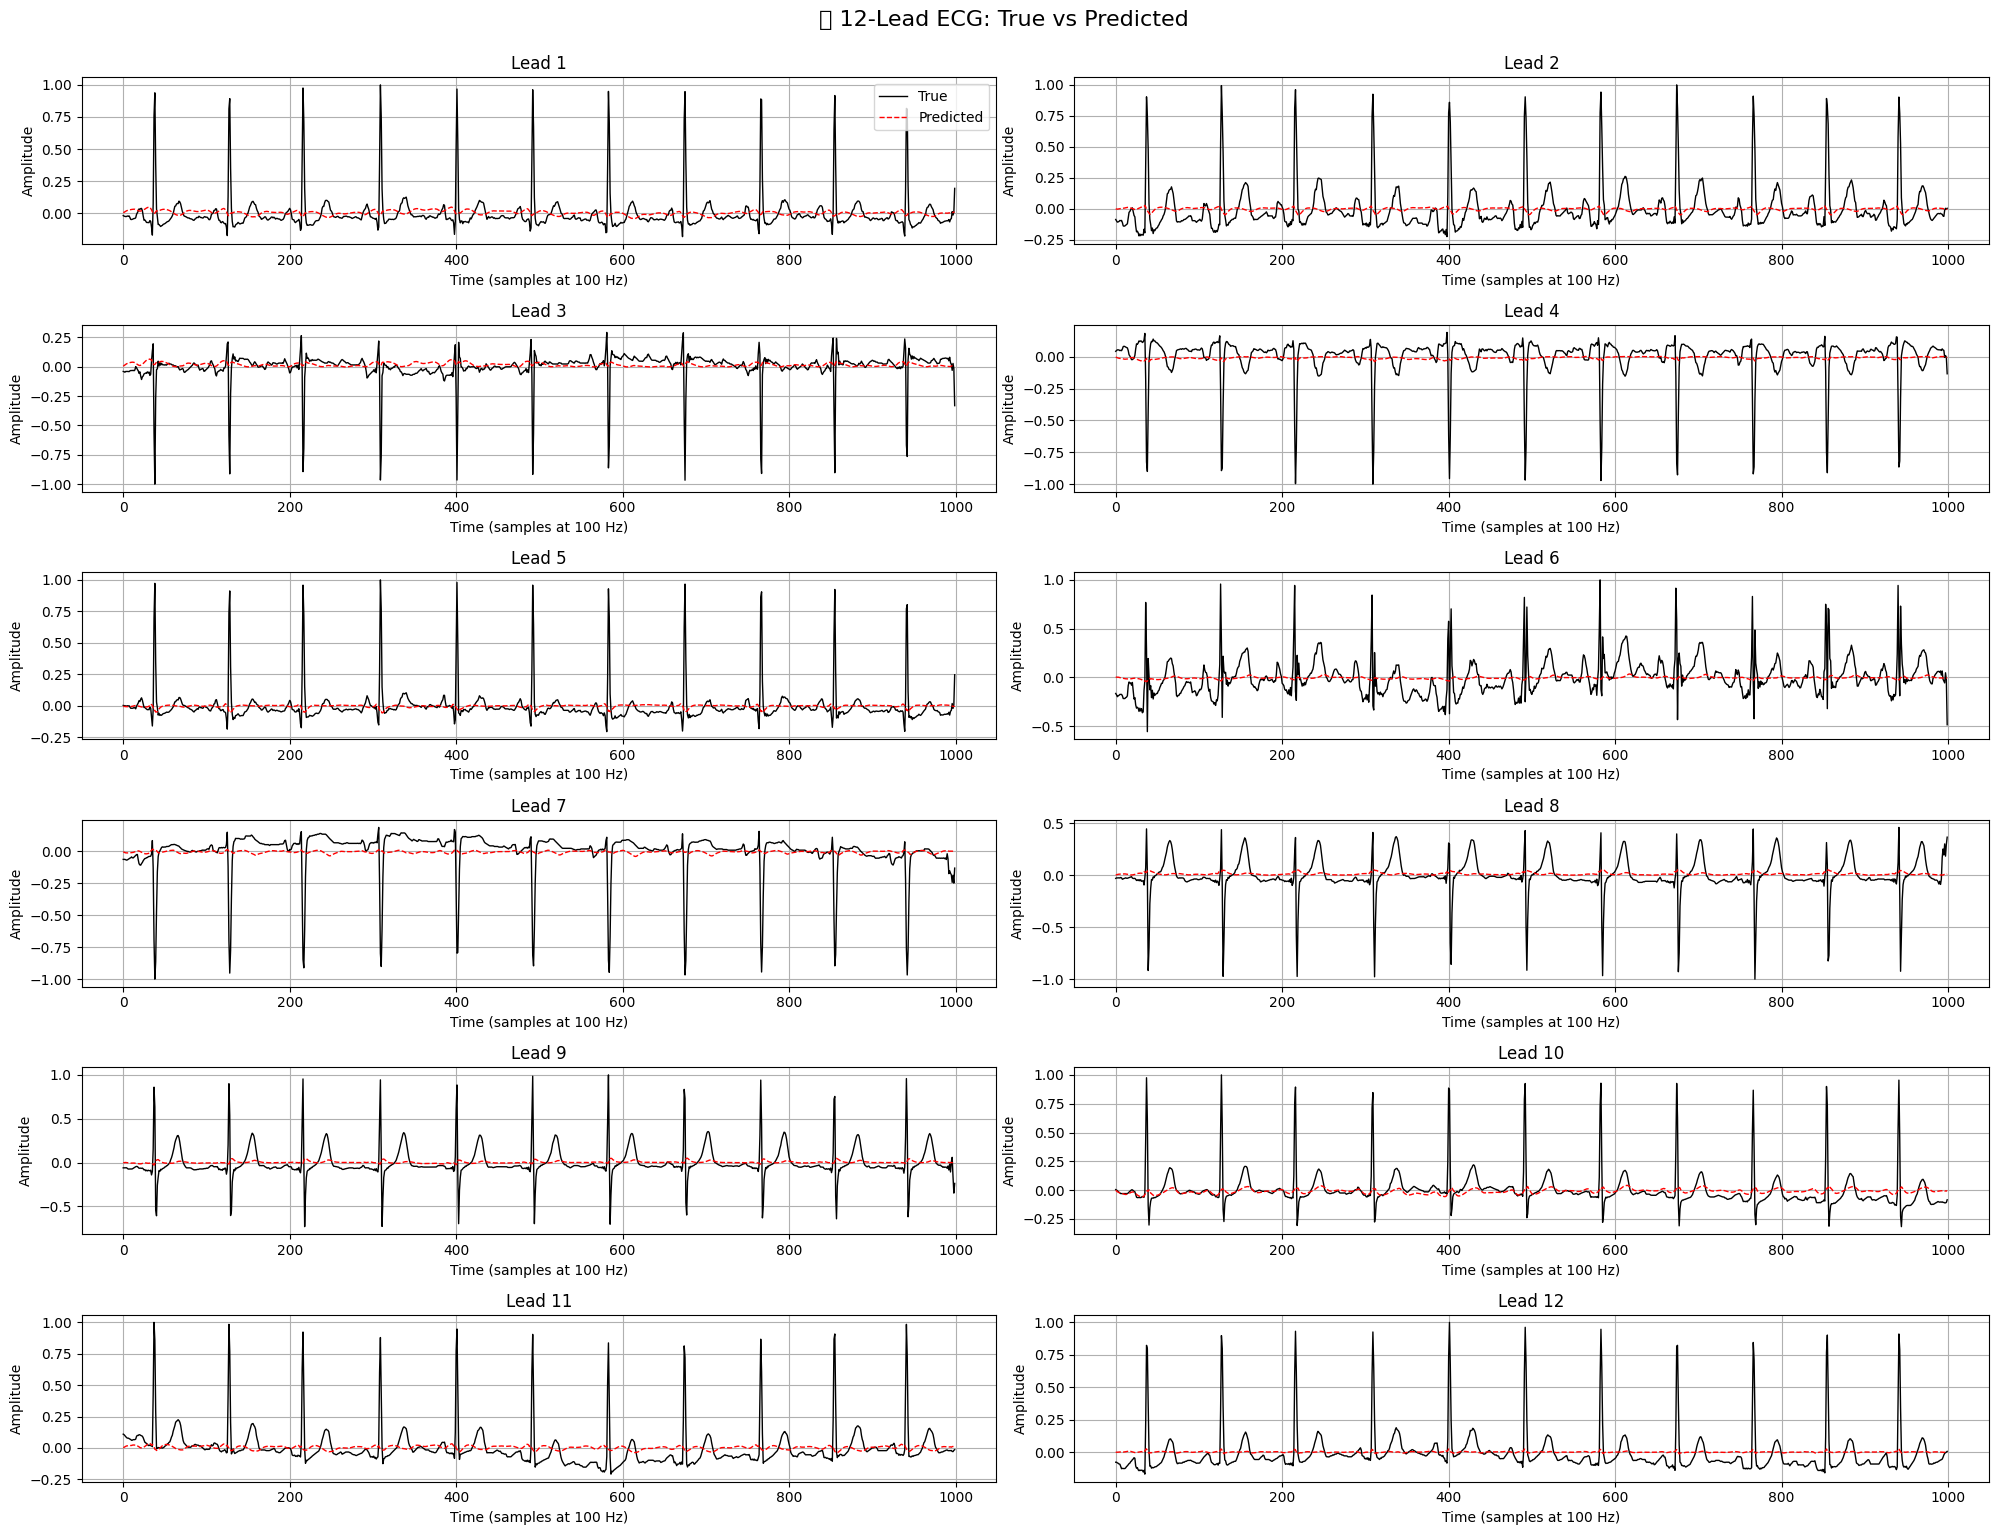

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Choose a sample index (0 to 4, since you predicted 5 samples)
sample_idx = 0

# Get the predicted and actual signals
pred = predicted_Y[sample_idx]    # Shape: (1000, 12)
true = Y_val[sample_idx]          # Shape: (1000, 12)

# Plot all 12 leads
plt.figure(figsize=(20, 15))
for i in range(12):
    plt.subplot(6, 2, i + 1)
    plt.plot(true[:, i], label='True', color='black', linewidth=1)
    plt.plot(pred[:, i], label='Predicted', color='red', linestyle='--', linewidth=1)
    plt.title(f"Lead {i+1}")
    plt.xlabel("Time (samples at 100 Hz)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    if i == 0:
        plt.legend(loc='upper right')

plt.tight_layout()
plt.suptitle("🔍 12-Lead ECG: True vs Predicted", fontsize=16, y=1.02)
plt.show()


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Predict on the full validation set
Y_pred = model.predict(X_val)

# Reshape if needed
Y_true = Y_val.reshape(-1)
Y_pred = Y_pred.reshape(-1)

# Calculate metrics
mae = mean_absolute_error(Y_true, Y_pred)
mse = mean_squared_error(Y_true, Y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(Y_true, Y_pred)

# Print results
print(f"MAE: {mae:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R² Score: {r2:.4f}")


137/137 ━━━━━━━━━━━━━━━━━━━━ 38s 274ms/step
MAE: 0.1143
MSE: 0.0360
RMSE: 0.1897
R² Score: -0.0217


In [ ]:
print("✅ Y_val shape:", Y_val.shape)
print("✅ Y_pred shape:", Y_pred.shape)


✅ Y_val shape: (4370, 1000, 12)
✅ Y_pred shape: (52440000,)


In [ ]:
# Infer time steps from Y_val
time_steps = Y_val.shape[1]
num_leads = 12

# Reshape Y_pred to match Y_val
Y_pred = Y_pred.reshape(-1, time_steps, num_leads)


In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]

print("📊 Per-Lead Accuracy on Validation Set:\n")

for i in range(num_leads):
    true_lead = Y_val[:, :, i].flatten()
    pred_lead = Y_pred[:, :, i].flatten()

    mae = mean_absolute_error(true_lead, pred_lead)
    mse = mean_squared_error(true_lead, pred_lead)
    rmse = np.sqrt(mse)
    r2 = r2_score(true_lead, pred_lead)

    print(f"🔹 Lead {lead_names[i]}:")
    print(f"   MAE  = {mae:.4f}")
    print(f"   RMSE = {rmse:.4f}")
    print(f"   R²   = {r2:.4f}\n")


📊 Per-Lead Accuracy on Validation Set:

🔹 Lead I:
   MAE  = 0.1066
   RMSE = 0.1771
   R²   = 0.0363

🔹 Lead II:
   MAE  = 0.1205
   RMSE = 0.1939
   R²   = -0.0200

🔹 Lead III:
   MAE  = 0.1193
   RMSE = 0.1882
   R²   = 0.0353

🔹 Lead aVR:
   MAE  = 0.1195
   RMSE = 0.1871
   R²   = -0.0439

🔹 Lead aVL:
   MAE  = 0.1149
   RMSE = 0.1902
   R²   = -0.0335

🔹 Lead aVF:
   MAE  = 0.1273
   RMSE = 0.1999
   R²   = -0.0285

🔹 Lead V1:
   MAE  = 0.1054
   RMSE = 0.1870
   R²   = -0.0222

🔹 Lead V2:
   MAE  = 0.1193
   RMSE = 0.1977
   R²   = 0.0179

🔹 Lead V3:
   MAE  = 0.1221
   RMSE = 0.2022
   R²   = 0.0074

🔹 Lead V4:
   MAE  = 0.1044
   RMSE = 0.1795
   R²   = 0.0225

🔹 Lead V5:
   MAE  = 0.1038
   RMSE = 0.1704
   R²   = 0.0120

🔹 Lead V6:
   MAE  = 0.1014
   RMSE = 0.1786
   R²   = -0.0068



In [ ]:
import os
import numpy as np
from tqdm import tqdm

# Folder containing the 500Hz batches
batch_dir = "/content/drive/MyDrive/PTB_processed_batches/500Hz_batches"
output_dir = "/content/drive/MyDrive/PTB_processed_batches"

# List all batch files
x_files = sorted([f for f in os.listdir(batch_dir) if f.startswith("X_batch_") and f.endswith(".npy")])
y_files = sorted([f for f in os.listdir(batch_dir) if f.startswith("Y_batch_") and f.endswith(".npy")])

assert len(x_files) == len(y_files), "Mismatch: Different number of X and Y batch files"

chunk_size = 3  # You can reduce to 2 if RAM is still tight
num_chunks = (len(x_files) + chunk_size - 1) // chunk_size

print(f"🔍 Found {len(x_files)} X and {len(y_files)} Y batches — Merging in chunks of {chunk_size}...")

for i in tqdm(range(num_chunks), desc="📦 Processing chunks"):
    start = i * chunk_size
    end = min(start + chunk_size, len(x_files))

    x_chunk = []
    y_chunk = []

    for j in range(start, end):
        x_path = os.path.join(batch_dir, x_files[j])
        y_path = os.path.join(batch_dir, y_files[j])
        x_chunk.append(np.load(x_path))
        y_chunk.append(np.load(y_path))

    # Concatenate chunk and save to Drive
    x_chunk = np.concatenate(x_chunk, axis=0)
    y_chunk = np.concatenate(y_chunk, axis=0)

    np.save(os.path.join(output_dir, f"X_500Hz_chunk_{i+1}.npy"), x_chunk)
    np.save(os.path.join(output_dir, f"Y_500Hz_chunk_{i+1}.npy"), y_chunk)

    # Free memory
    del x_chunk, y_chunk

print("✅ All chunks processed and saved safely to Google Drive.")


🔍 Found 22 X and 22 Y batches — Merging in chunks of 3...


📦 Processing chunks: 100%|██████████| 8/8 [08:38<00:00, 64.81s/it]

✅ All chunks processed and saved safely to Google Drive.


In [ ]:
import os
import numpy as np
from tqdm import tqdm

# Set chunk directory
chunk_dir = "/content/drive/MyDrive/PTB_processed_batches"

# Get list of X chunk files
x_chunk_files = sorted([f for f in os.listdir(chunk_dir) if f.startswith("X_500Hz_chunk_") and f.endswith(".npy")])
print(f"🔍 Found {len(x_chunk_files)} X_500Hz chunks")

# Merge X chunks
X_final = []

for fname in tqdm(x_chunk_files, desc="🔄 Merging X_500Hz chunks"):
    x_part = np.load(os.path.join(chunk_dir, fname), mmap_mode='r')
    X_final.append(np.array(x_part))  # Convert from mmap to regular array

X_final = np.concatenate(X_final, axis=0)

# Save final merged X
np.save(os.path.join(chunk_dir, "X_500Hz.npy"), X_final)
print(f"✅ Final X shape: {X_final.shape}")
print("📁 Saved: X_500Hz.npy")


🔍 Found 8 X_500Hz chunks


🔄 Merging X_500Hz chunks: 100%|██████████| 8/8 [00:35<00:00,  4.43s/it]


✅ Final X shape: (21841, 5000, 3)
📁 Saved: X_500Hz.npy


In [ ]:
import os
import numpy as np
from tqdm import tqdm

chunk_dir = "/content/drive/MyDrive/PTB_processed_batches"

# Get sorted list of chunk files
y_chunk_files = sorted([f for f in os.listdir(chunk_dir) if f.startswith("Y_500Hz_chunk_") and f.endswith(".npy")])
print(f"🔍 Found {len(y_chunk_files)} Y_500Hz chunks")

# First pass: Get total shape
total_rows = 0
sample_shape = None

for fname in y_chunk_files:
    y_part = np.load(os.path.join(chunk_dir, fname), mmap_mode='r')
    total_rows += y_part.shape[0]
    if sample_shape is None:
        sample_shape = y_part.shape[1:]  # e.g., () or (n_classes,)

# Create memmap array
final_path = os.path.join(chunk_dir, "Y_500Hz.npy")
Y_final = np.memmap(final_path, dtype='float32', mode='w+', shape=(total_rows, *sample_shape))

# Second pass: Write data in chunks
start = 0
for fname in tqdm(y_chunk_files, desc="🔄 Writing Y_500Hz chunks to final array"):
    y_part = np.load(os.path.join(chunk_dir, fname), mmap_mode='r')
    end = start + y_part.shape[0]
    Y_final[start:end] = y_part
    start = end

# Flush to disk
Y_final.flush()
print(f"✅ Final Y shape: {Y_final.shape}")
print("📁 Saved: Y_500Hz.npy")


🔍 Found 8 Y_500Hz chunks


🔄 Writing Y_500Hz chunks to final array: 100%|██████████| 8/8 [01:43<00:00, 12.95s/it]

✅ Final Y shape: (21841, 5000, 12)
📁 Saved: Y_500Hz.npy


In [ ]:
import os

file_path = "/content/drive/MyDrive/PTB_processed_batches/Y_500Hz.npy"
print("✅ Exists:", os.path.exists(file_path))
print("📏 Size (MB):", round(os.path.getsize(file_path) / (1024 * 1024), 2))


✅ Exists: True
📏 Size (MB): 4999.01


In [ ]:
import numpy as np
import os

folder = '/content/drive/MyDrive/PTB_processed_batches'
y_chunk_files = sorted([
    f for f in os.listdir(folder)
    if f.startswith("Y_500Hz_chunk_") and f.endswith(".npy")
])

print(f"Found {len(y_chunk_files)} Y chunk files.")

# First chunk: create the output file with proper shape
first_chunk = np.load(os.path.join(folder, y_chunk_files[0]))
num_total = 0
out_shape = (0,) + first_chunk.shape[1:]
dtype = first_chunk.dtype

# Estimate final total shape
for f in y_chunk_files:
    data = np.load(os.path.join(folder, f))
    num_total += data.shape[0]

# Create memory-mapped output file
output_path = os.path.join(folder, 'Y_500Hz.npy')
Y_500Hz_memmap = np.lib.format.open_memmap(
    output_path,
    mode='w+',
    dtype=dtype,
    shape=(num_total,) + first_chunk.shape[1:]
)

# Fill the memmap file chunk by chunk
start = 0
for f in y_chunk_files:
    data = np.load(os.path.join(folder, f))
    end = start + data.shape[0]
    Y_500Hz_memmap[start:end] = data
    print(f"Wrote chunk {f} to indices {start}:{end}")
    start = end

print(f"✅ Successfully created memory-efficient merged file: {output_path}")

Found 8 Y chunk files.
Wrote chunk Y_500Hz_chunk_1.npy to indices 0:3000
Wrote chunk Y_500Hz_chunk_2.npy to indices 3000:5999
Wrote chunk Y_500Hz_chunk_3.npy to indices 5999:8999
Wrote chunk Y_500Hz_chunk_4.npy to indices 8999:11999
Wrote chunk Y_500Hz_chunk_5.npy to indices 11999:14841
Wrote chunk Y_500Hz_chunk_6.npy to indices 14841:17841
Wrote chunk Y_500Hz_chunk_7.npy to indices 17841:20841
Wrote chunk Y_500Hz_chunk_8.npy to indices 20841:21841
✅ Successfully created memory-efficient merged file: /content/drive/MyDrive/PTB_processed_batches/Y_500Hz.npy


In [ ]:
import os

batch_dir = '/content/drive/MyDrive/PTB_processed_batches'
files = os.listdir(batch_dir)
print("Files in folder:")
print(files)

Files in folder:
['100Hz_batches', '500Hz_batches', 'X_100Hz.npy', 'Y_100Hz.npy', 'X_500Hz_chunk_1.npy', 'Y_500Hz_chunk_1.npy', 'X_500Hz_chunk_2.npy', 'Y_500Hz_chunk_2.npy', 'X_500Hz_chunk_3.npy', 'Y_500Hz_chunk_3.npy', 'X_500Hz_chunk_4.npy', 'Y_500Hz_chunk_4.npy', 'X_500Hz_chunk_5.npy', 'Y_500Hz_chunk_5.npy', 'X_500Hz_chunk_6.npy', 'Y_500Hz_chunk_6.npy', 'X_500Hz_chunk_7.npy', 'Y_500Hz_chunk_7.npy', 'X_500Hz_chunk_8.npy', 'Y_500Hz_chunk_8.npy', 'Y_500Hz.npy', 'X_500Hz.npy']


In [ ]:
import numpy as np

# Load using memory mapping (does not load entire file into RAM)
X = np.load('/content/drive/MyDrive/PTB_processed_batches/X_500Hz.npy', mmap_mode='r')
Y = np.load('/content/drive/MyDrive/PTB_processed_batches/Y_500Hz.npy', mmap_mode='r')

print(f"✅ X shape: {X.shape}, Y shape: {Y.shape}")


✅ X shape: (21841, 5000, 3), Y shape: (21841, 5000, 12)


In [ ]:
from sklearn.model_selection import train_test_split

indices = np.arange(X.shape[0])
train_indices, val_indices = train_test_split(indices, test_size=0.2, random_state=42)

print(f"Train size: {len(train_indices)}, Validation size: {len(val_indices)}")


Train size: 17472, Validation size: 4369


In [ ]:
from tensorflow.keras.utils import Sequence

class ECGDataGenerator(Sequence):
    def __init__(self, X, Y, indices, batch_size=4, max_timesteps=2500, shuffle=True):
        self.X = X
        self.Y = Y
        self.indices = indices
        self.batch_size = batch_size
        self.max_timesteps = max_timesteps
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.indices) / self.batch_size))

    def __getitem__(self, index):
        batch_indices = self.indices[index * self.batch_size:(index + 1) * self.batch_size]
        X_batch = self.X[batch_indices, :self.max_timesteps, :]
        Y_batch = self.Y[batch_indices, :self.max_timesteps, :]
        return np.array(X_batch), np.array(Y_batch)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indices)


In [ ]:
batch_size = 4
max_timesteps = 1000
train_gen = ECGDataGenerator(X, Y, train_indices, batch_size=4, max_timesteps=max_timesteps)
val_gen = ECGDataGenerator(X, Y, val_indices, batch_size=4, max_timesteps=max_timesteps)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, TimeDistributed

input_layer = Input(shape=(max_timesteps, 3))  # 3 leads input
x = Conv1D(64, kernel_size=7, padding='same', activation='relu')(input_layer)
x = LSTM(128, return_sequences=True)(x)
x = TimeDistributed(Dense(12))(x)  # Output: 12 leads

model = Model(inputs=input_layer, outputs=x)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 1000, 3)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_5 (Conv1D)               │ (None, 1000, 64)       │         1,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 1000, 128)      │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_3              │ (None, 1000, 12)       │         1,548 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,772 (397.55 KB)

 Trainable params: 101,772 (397.55 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
x_sample, y_sample = train_gen[0]
print("Sample X shape:", x_sample.shape)
print("Sample Y shape:", y_sample.shape)


Sample X shape: (4, 1000, 3)
Sample Y shape: (4, 1000, 12)


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, TimeDistributed

input_layer = Input(shape=(max_timesteps, 3))  # 3 leads input
x = Conv1D(64, kernel_size=7, padding='same', activation='relu')(input_layer)
x = LSTM(128, return_sequences=True)(x)
x = TimeDistributed(Dense(12))(x)  # Output: 12 leads


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Optional: Load an existing model to continue training
# from tensorflow.keras.models import load_model
# model = load_model("/content/drive/MyDrive/PTB_model_500Hz_round3.keras")  # If resuming

for round_num in range(1, 5):  # 4 rounds × 5 = 20 epochs
    print(f"\n🔁 Starting training chunk {round_num}...")

    # Use a temporary name for rounds 1-3, final save as desired name
    if round_num < 4:
        checkpoint_path = f"/content/drive/MyDrive/PTB_model_500Hz_round{round_num}.keras"
    else:
        checkpoint_path = "/content/drive/MyDrive/PTB_model_500Hz.keras"

    checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)
    early_stop = EarlyStopping(patience=3, restore_best_weights=True)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,
        callbacks=[checkpoint, early_stop]
    )

    print(f"✅ Finished round {round_num}, model saved at {checkpoint_path}")





🔁 Starting training chunk 1...
Epoch 1/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7516s 2s/step - loss: 0.0120 - mae: 0.0579 - val_loss: 0.0103 - val_mae: 0.0518
Epoch 2/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7365s 2s/step - loss: 0.0100 - mae: 0.0514 - val_loss: 0.0102 - val_mae: 0.0509
Epoch 3/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7381s 2s/step - loss: 0.0097 - mae: 0.0496 - val_loss: 0.0096 - val_mae: 0.0485
Epoch 4/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7515s 2s/step - loss: 0.0094 - mae: 0.0482 - val_loss: 0.0094 - val_mae: 0.0478
Epoch 5/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7534s 2s/step - loss: 0.0094 - mae: 0.0475 - val_loss: 0.0093 - val_mae: 0.0474
✅ Finished round 1, model saved at /content/drive/MyDrive/PTB_model_500Hz_round1.keras

🔁 Starting training chunk 2...
Epoch 1/5
2111/4368 ━━━━━━━━━━━━━━━━━━━━ 1:03:10 2s/step - loss: 0.0092 - mae: 0.0471

In [ ]:
# Re-import libraries
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Re-create your generators exactly as before
# (Assuming you already defined train_gen and val_gen)


In [ ]:

model = load_model(
    "/content/drive/MyDrive/PTB_model_500Hz_round1.keras")


In [ ]:
for round_num in range(2, 5):  # Rounds 2, 3, and 4
    print(f"\n🔁 Starting training chunk {round_num}...")

    # Final round saves to final model name
    if round_num == 4:
        checkpoint_path = "/content/drive/MyDrive/PTB_model_500Hz.keras"
    else:
        checkpoint_path = f"/content/drive/MyDrive/PTB_model_500Hz_round{round_num}.keras"

    checkpoint = ModelCheckpoint(checkpoint_path, save_best_only=True)
    early_stop = EarlyStopping(patience=3, restore_best_weights=True)

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=5,
        callbacks=[checkpoint, early_stop]
    )

    print(f"✅ Finished round {round_num}, model saved at {checkpoint_path}")



🔁 Starting training chunk 2...
Epoch 1/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7427s 2s/step - loss: 0.0091 - mae: 0.0466 - val_loss: 0.0093 - val_mae: 0.0470
Epoch 2/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7189s 2s/step - loss: 0.0091 - mae: 0.0463 - val_loss: 0.0091 - val_mae: 0.0464
Epoch 3/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7013s 2s/step - loss: 0.0089 - mae: 0.0456 - val_loss: 0.0090 - val_mae: 0.0454
Epoch 4/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7177s 2s/step - loss: 0.0087 - mae: 0.0450 - val_loss: 0.0089 - val_mae: 0.0452
Epoch 5/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7177s 2s/step - loss: 0.0087 - mae: 0.0445 - val_loss: 0.0089 - val_mae: 0.0445
✅ Finished round 2, model saved at /content/drive/MyDrive/PTB_model_500Hz_round2.keras

🔁 Starting training chunk 3...
Epoch 1/5
4217/4368 ━━━━━━━━━━━━━━━━━━━━ 4:03 2s/step - loss: 0.0085 - mae: 0.0439

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Step 1: Load model from round 2
model = load_model(
    "/content/drive/MyDrive/PTB_model_500Hz_round2.keras")



In [ ]:
# Step 2: Set up checkpoint to save after every epoch
checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/checkpoints/epoch_chunk3_{epoch:02d}.keras",
    save_best_only=False,  # Save every epoch
    save_freq='epoch'
)
# Step 3: Early stopping (optional, just in case)
early_stop = EarlyStopping(patience=3, restore_best_weights=True)


In [ ]:
# Step 4: Train for 5 more epochs (chunk 3)
print("🔁 Starting training chunk 3 (epochs 11–15)...")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[checkpoint, early_stop]
)

# Step 5: Save final model after chunk 3
model.save("/content/drive/MyDrive/PTB_model_500Hz_round3.keras")

print("✅ Finished training chunk 3.")

🔁 Starting training chunk 3 (epochs 11–15)...
Epoch 1/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7821s 2s/step - loss: 0.0086 - mae: 0.0441 - val_loss: 0.0088 - val_mae: 0.0443
Epoch 2/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7051s 2s/step - loss: 0.0084 - mae: 0.0436 - val_loss: 0.0088 - val_mae: 0.0445
Epoch 3/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7376s 2s/step - loss: 0.0084 - mae: 0.0435 - val_loss: 0.0087 - val_mae: 0.0435
Epoch 4/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7940s 2s/step - loss: 0.0083 - mae: 0.0431 - val_loss: 0.0087 - val_mae: 0.0437
Epoch 5/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 8174s 2s/step - loss: 0.0083 - mae: 0.0430 - val_loss: 0.0086 - val_mae: 0.0437
✅ Finished training chunk 3.


In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Step 1: Load the latest trained model from round 3
model = load_model(
    "/content/drive/MyDrive/PTB_model_500Hz_round3.keras")



In [ ]:
# Step 2: Setup checkpointing to save after each epoch
checkpoint = ModelCheckpoint(
    filepath="/content/drive/MyDrive/checkpoints/epoch_chunk4_{epoch:02d}.keras",
    save_best_only=False,  # Save every epoch
    save_freq='epoch'
)

# Step 3: Early stopping (optional for safety)
early_stop = EarlyStopping(patience=3, restore_best_weights=True)


In [ ]:
# Step 4: Train for the final 5 epochs
print("🔁 Starting training chunk 4 (epochs 16–20)...")

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=5,
    callbacks=[checkpoint, early_stop]
)

# Step 5: Save final model after chunk 4
model.save("/content/drive/MyDrive/PTB_model_500Hz_round4.keras")

print("✅ Finished training chunk 4.")

# Step 6: Save the final complete model
model.save("/content/drive/MyDrive/PTB_model_500Hz.keras")
print("✅ Finished training chunk 4. Final model saved as PTB_model_500Hz.keras")

🔁 Starting training chunk 4 (epochs 16–20)...
Epoch 1/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 7557s 2s/step - loss: 0.0082 - mae: 0.0429 - val_loss: 0.0087 - val_mae: 0.0442
Epoch 2/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 6806s 2s/step - loss: 0.0083 - mae: 0.0430 - val_loss: 0.0086 - val_mae: 0.0434
Epoch 3/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 6182s 1s/step - loss: 0.0082 - mae: 0.0426 - val_loss: 0.0086 - val_mae: 0.0437
Epoch 4/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 6310s 1s/step - loss: 0.0081 - mae: 0.0424 - val_loss: 0.0086 - val_mae: 0.0441
Epoch 5/5
4368/4368 ━━━━━━━━━━━━━━━━━━━━ 6249s 1s/step - loss: 0.0082 - mae: 0.0426 - val_loss: 0.0087 - val_mae: 0.0448
✅ Finished training chunk 4.
✅ Finished training chunk 4. Final model saved as PTB_model_500Hz.keras


In [ ]:
# Step 5: Save final model after chunk 4
model.save("/content/drive/MyDrive/PTB_model_500Hz_round4.keras")

print("✅ Finished training chunk 4.")


✅ Finished training chunk 4.


In [ ]:
# Step 6: Save the final complete model
model.save("/content/drive/MyDrive/PTB_model_500Hz.keras")
print("✅ Finished training chunk 4. Final model saved as PTB_model_500Hz.keras")

✅ Finished training chunk 4. Final model saved as PTB_model_500Hz.keras


In [ ]:
from tensorflow.keras.models import load_model

reconstruction_model = load_model("/content/drive/MyDrive/PTB_model_500Hz.keras")


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Pick one validation sample (e.g., first one)
i = val_indices[0]  # Or any index you want
x_input = X[i][:1000]  # (1000, 3)
x_input = np.expand_dims(x_input, axis=0)  # Shape: (1, 1000, 3)

# Get ground truth and prediction
y_true = Y[i][:1000]          # Shape: (1000, 12)
y_pred = reconstruction_model.predict(x_input)[0]  # Shape: (1000, 12)


1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step


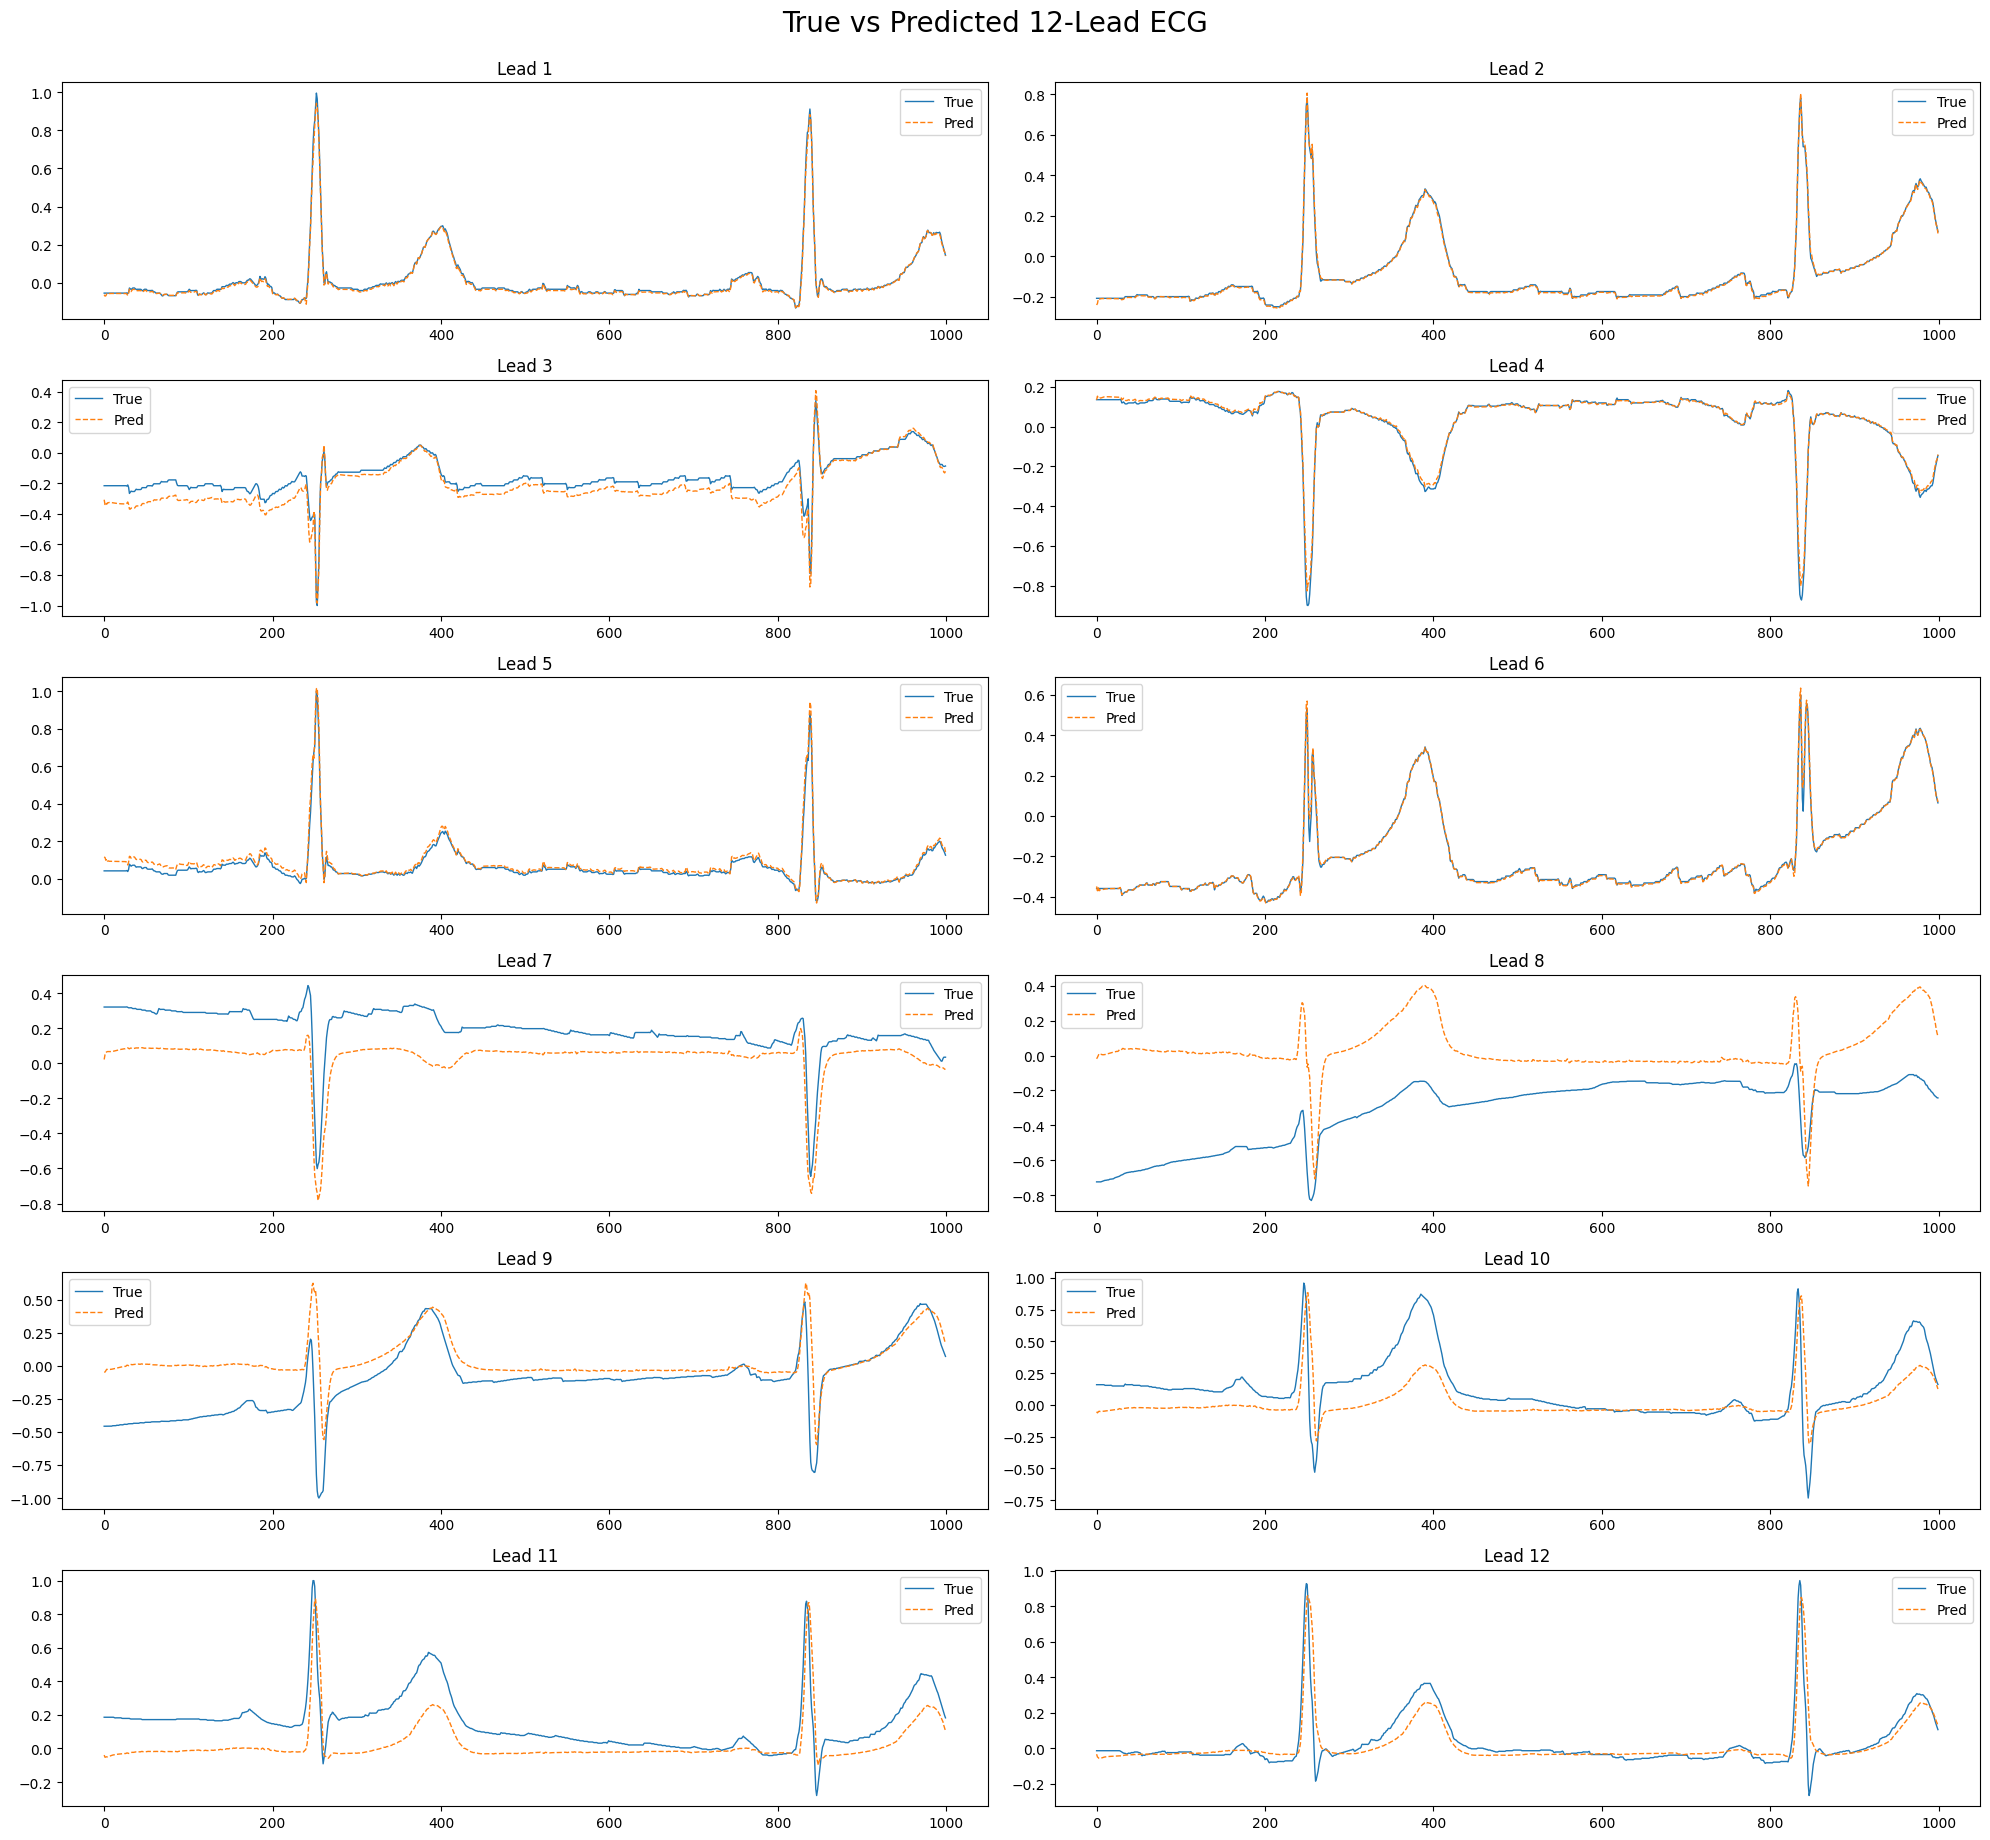

In [ ]:
# Plot all 12 leads
plt.figure(figsize=(20, 18))
for lead in range(12):
    plt.subplot(6, 2, lead + 1)
    plt.plot(y_true[:, lead], label="True", linewidth=1)
    plt.plot(y_pred[:, lead], label="Pred", linestyle='--', linewidth=1)
    plt.title(f"Lead {lead + 1}")
    plt.legend()
    plt.tight_layout()

plt.suptitle("True vs Predicted 12-Lead ECG", fontsize=20, y=1.02)
plt.show()

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from tqdm import tqdm


In [ ]:
# Store all errors
mse_per_lead = []
corr_per_lead = []

In [ ]:
# Evaluate over a few samples from the validation set
num_samples = 100  # You can increase this if RAM allows

In [ ]:
for idx in tqdm(val_indices[:num_samples]):
    x = X[idx][:1000]  # shape: (1000, 3)
    y_true = Y[idx][:1000]  # shape: (1000, 12)

    x_input = np.expand_dims(x, axis=0)  # shape: (1, 1000, 3)
    y_pred = reconstruction_model.predict(x_input, verbose=0)[0]  # (1000, 12)

    for lead in range(12):
        mse = mean_squared_error(y_true[:, lead], y_pred[:, lead])
        corr, _ = pearsonr(y_true[:, lead], y_pred[:, lead])

        mse_per_lead.append(mse)
        corr_per_lead.append(corr)

100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


In [ ]:
# Convert to arrays and reshape
mse_per_lead = np.array(mse_per_lead).reshape(-1, 12)
corr_per_lead = np.array(corr_per_lead).reshape(-1, 12)

In [ ]:
# Print average metrics per lead
print("\n📊 Average MSE per Lead:")
for lead in range(12):
    print(f"Lead {lead + 1}: {mse_per_lead[:, lead].mean():.4f}")



📊 Average MSE per Lead:
Lead 1: 0.0001
Lead 2: 0.0001
Lead 3: 0.0019
Lead 4: 0.0010
Lead 5: 0.0018
Lead 6: 0.0001
Lead 7: 0.0188
Lead 8: 0.0276
Lead 9: 0.0258
Lead 10: 0.0189
Lead 11: 0.0131
Lead 12: 0.0186


In [ ]:
print("\n📈 Average Pearson Correlation per Lead:")
for lead in range(12):
    print(f"Lead {lead + 1}: {corr_per_lead[:, lead].mean():.4f}")


📈 Average Pearson Correlation per Lead:
Lead 1: 0.9991
Lead 2: 0.9990
Lead 3: 0.9814
Lead 4: 0.9938
Lead 5: 0.9807
Lead 6: 0.9990
Lead 7: 0.8159
Lead 8: 0.7299
Lead 9: 0.6789
Lead 10: 0.7495
Lead 11: 0.8639
Lead 12: 0.8427


In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_error
from scipy.stats import pearsonr
from tqdm import tqdm


In [ ]:
y_true_all = []
y_pred_all = []

num_samples = 100  # You can adjust this as needed


In [ ]:
# Collect predictions and ground truths
for idx in tqdm(val_indices[:num_samples]):
    x = X[idx][:1000]  # (1000, 3)
    y_true = Y[idx][:1000]  # (1000, 12)

    x_input = np.expand_dims(x, axis=0)  # (1, 1000, 3)
    y_pred = reconstruction_model.predict(x_input, verbose=0)[0]  # (1000, 12)

    y_true_all.append(y_true)
    y_pred_all.append(y_pred)

100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


In [ ]:
# Stack all predictions and ground truths
y_true_all = np.concatenate(y_true_all, axis=0).flatten()
y_pred_all = np.concatenate(y_pred_all, axis=0).flatten()

In [ ]:
# Combined metrics
global_mse = mean_squared_error(y_true_all, y_pred_all)
global_corr, _ = pearsonr(y_true_all, y_pred_all)


In [ ]:

print(f"\n✅ Global MSE across all leads: {global_mse:.6f}")
print(f"✅ Global Pearson Correlation (r): {global_corr:.4f}")


✅ Global MSE across all leads: 0.010644
✅ Global Pearson Correlation (r): 0.8494


In [ ]:
#classifier model

In [ ]:
# ✅ ECG Classification Pipeline
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
# STEP 1: Load ECG signal data (12-lead, 100Hz)
X = np.load("/content/drive/MyDrive/PTB_processed_batches/Y_100Hz.npy", mmap_mode='r')
print("Loaded X shape:", X.shape)  # Should be (21847, 1000, 12)

Loaded X shape: (21847, 1000, 12)


In [ ]:
# Step 2: Load metadata
df = pd.read_csv("/content/drive/MyDrive/PTB-data/ptbxl_database.csv")

In [ ]:
# Step 3: Match ECG data with labels
# Assume each row in X corresponds to the order of df["filename_lr"] sorted
df = df.sort_values("filename_lr").reset_index(drop=True)

# Extract diagnostic labels from 'scp_codes' column
df["scp_codes"] = df["scp_codes"].apply(eval)
df["diagnostic_codes"] = df["scp_codes"].apply(lambda d: [k for k in d.keys()])


In [ ]:
# Step 4: Filter top 4 diagnostic classes (optional)
all_labels = [label for sublist in df["diagnostic_codes"].tolist() for label in sublist]
top_labels = pd.Series(all_labels).value_counts().head(4).index.tolist()

df["filtered_labels"] = df["diagnostic_codes"].apply(lambda codes: [code for code in codes if code in top_labels])
df = df[df["filtered_labels"].str.len() > 0].reset_index(drop=True)


In [ ]:
# Step 5: Match filtered ECG data
X = X[:len(df)]  # Trim to match label count

In [ ]:
# Step 6: One-hot encode labels
mlb = MultiLabelBinarizer(classes=top_labels)
Y = mlb.fit_transform(df["filtered_labels"])

print("✅ X shape:", X.shape)  # (samples, 1000, 12)
print("✅ Y shape:", Y.shape)  # (samples, 4)


✅ X shape: (19215, 1000, 12)
✅ Y shape: (19215, 4)


In [ ]:
# Step 8: Define classifier model
model = Sequential([
    Conv1D(32, 5, activation='relu', input_shape=(1000, 12)),
    MaxPooling1D(2),
    Conv1D(64, 5, activation='relu'),
    MaxPooling1D(2),
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(len(top_labels), activation='sigmoid')  # Multi-label
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Step 9: Train the model
checkpoint = ModelCheckpoint("/content/drive/MyDrive/classifier_model_100Hz.keras", save_best_only=True)

history = model.fit(
    X_train, Y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[checkpoint]
)

print("🎉 Training completed and model saved to Google Drive.")

Epoch 1/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 25s 49ms/step - accuracy: 0.8633 - loss: 0.5055 - val_accuracy: 0.8774 - val_loss: 0.4848
Epoch 2/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.8740 - loss: 0.4837 - val_accuracy: 0.8774 - val_loss: 0.4870
Epoch 3/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.8701 - loss: 0.4725 - val_accuracy: 0.8774 - val_loss: 0.4951
Epoch 4/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 40s 49ms/step - accuracy: 0.8735 - loss: 0.4409 - val_accuracy: 0.8774 - val_loss: 0.5120
Epoch 5/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.8729 - loss: 0.3962 - val_accuracy: 0.8699 - val_loss: 0.5544
Epoch 6/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.8724 - loss: 0.3232 - val_accuracy: 0.8316 - val_loss: 0.6187
Epoch 7/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 42s 50ms/step - accuracy: 0.8618 - loss: 0.2433 - val_accuracy: 0.7965 - val_loss: 0.7239
Epoch 8/30
481/481 ━━━━━━━━━━━━━━━━━━━━ 41s 49ms/step - accuracy: 0.8505 - loss: 0.1768 - 

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np

# Step 1: Load models
reconstruction_model = load_model("/content/drive/MyDrive/PTB_model_100Hz.keras")
classifier = load_model("/content/drive/MyDrive/classifier_model_100Hz.keras")




In [ ]:
#input and output

!pip install -q opencv-python matplotlib tensorflow

import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from google.colab import files


In [ ]:
# Step 1: Upload Image
from google.colab import files
from PIL import Image
import io

uploaded = files.upload()

for fn in uploaded:
    if fn.endswith((".png", ".jpg", ".jpeg")):
        image = Image.open(io.BytesIO(uploaded[fn])).convert("RGB")
        print("✅ ECG image loaded:", fn)
        image.show()
    else:
        print("⚠️ Please upload a valid ECG image (PNG/JPG).")
        raise ValueError("Invalid file type.")






Saving Screenshot 2025-07-31 204406.png to Screenshot 2025-07-31 204406.png
✅ ECG image loaded: Screenshot 2025-07-31 204406.png


In [ ]:
# Step 2: Load and show the image
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.title("Uploaded ECG Image")
plt.axis("off")
plt.show()

NameError: name 'image_path' is not defined

In [ ]:
# ✅ STEP 2: Load trained ECG reconstruction model
from tensorflow.keras.models import load_model

# Your saved 3-lead to 12-lead model (trained on 500Hz data)
model_path = "/content/drive/MyDrive/PTB_model_500Hz.keras"
reconstruction_model = load_model(model_path)
print("✅ Reconstruction model loaded.")



✅ Reconstruction model loaded.


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 20 variables whereas the saved optimizer has 2 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
# ✅ STEP 3: Define functions for lead extraction
import numpy as np
import cv2

def extract_lead_regions(image_pil):
    """Crop regions for leads I, II, and V2 from the ECG image."""
    image = np.array(image_pil)
    image = cv2.resize(image, (1600, 1200))  # Resize for consistent cropping

    lead_I = image[200:300, 100:1500]   # Adjust based on your image layout
    lead_II = image[350:450, 100:1500]
    lead_V2 = image[500:600, 100:1500]

    return lead_I, lead_II, lead_V2

In [ ]:
def extract_waveform_from_lead(lead_img):
    """Convert image of a lead into a 1D normalized waveform signal."""
    gray = cv2.cvtColor(lead_img, cv2.COLOR_RGB2GRAY)
    _, binary = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)
    signal = np.argmax(binary, axis=0)  # Find peak in each column
    signal = (signal - np.min(signal)) / (np.max(signal) - np.min(signal))  # Normalize
    return signal

In [ ]:
def prepare_input(image_pil):
    """Prepares (1000, 3) input for model from ECG image."""
    I_img, II_img, V2_img = extract_lead_regions(image_pil)
    lead_I = extract_waveform_from_lead(I_img)
    lead_II = extract_waveform_from_lead(II_img)
    lead_V2 = extract_waveform_from_lead(V2_img)

    # Resize each lead to 1000 samples (to match 100Hz)
    lead_I = cv2.resize(lead_I.reshape(1, -1), (1000, 1)).flatten()
    lead_II = cv2.resize(lead_II.reshape(1, -1), (1000, 1)).flatten()
    lead_V2 = cv2.resize(lead_V2.reshape(1, -1), (1000, 1)).flatten()

    combined = np.stack([lead_I, lead_II, lead_V2], axis=1)  # shape: (1000, 3)
    return combined


In [ ]:
# ✅ STEP 4: Run ECG reconstruction
input_3lead = prepare_input(image)                  # (1000, 3)
input_model = input_3lead.reshape(1, 1000, 3)       # (1, 1000, 3)
predicted_12lead = reconstruction_model.predict(input_model)[0]  # (1000, 12)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


In [ ]:
predicted_12lead = model.predict(input_model)[0]  # shape: (1000, 12)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


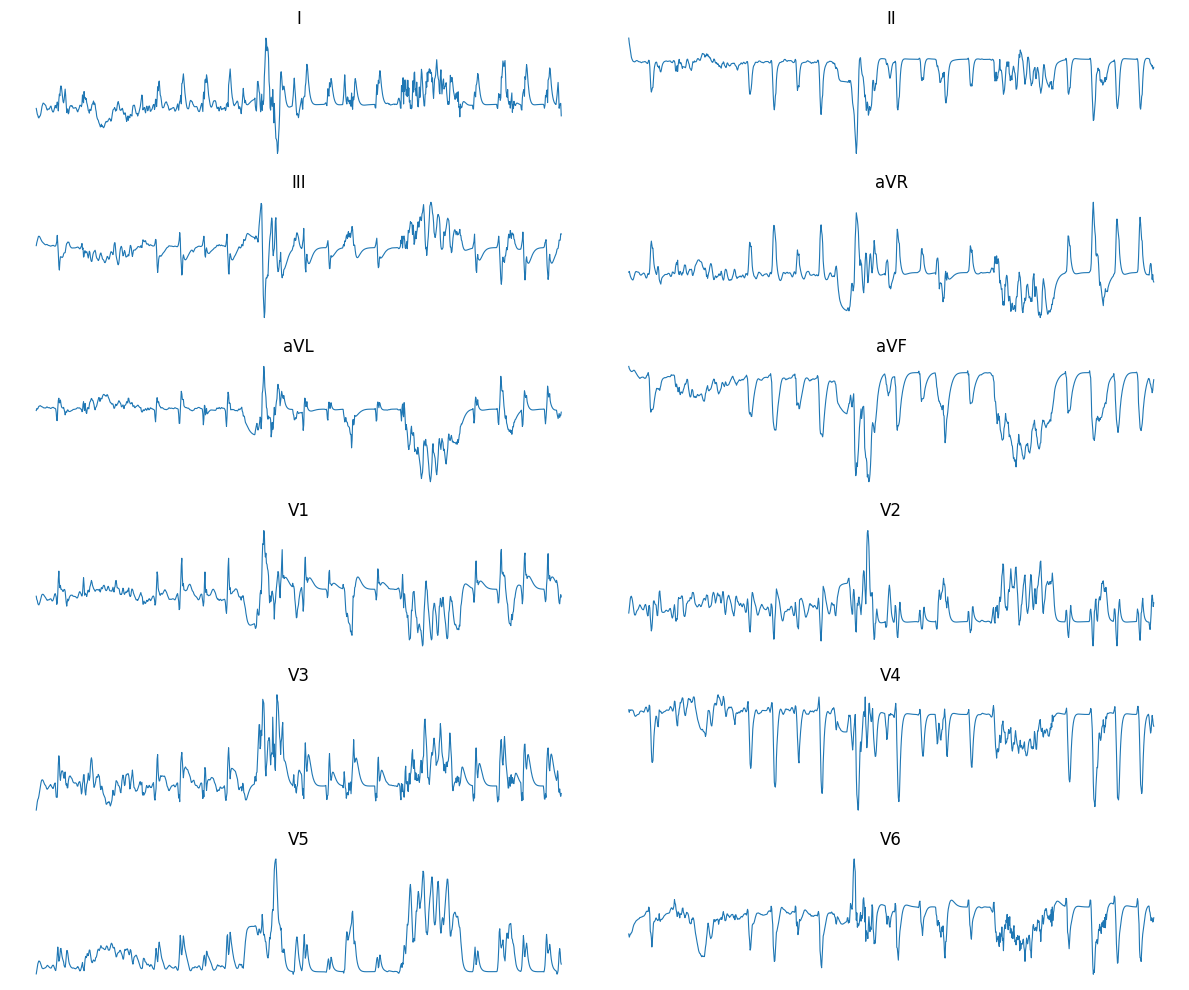

In [ ]:
# ✅ STEP 5: Plot reconstructed 12-lead ECG
import matplotlib.pyplot as plt

def plot_12lead_ecg(prediction):
    fig, axs = plt.subplots(6, 2, figsize=(12, 10))
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF',
                  'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    for i, ax in enumerate(axs.flat):
        ax.plot(prediction[:, i], linewidth=0.8)
        ax.set_title(lead_names[i])
        ax.axis('off')

    plt.tight_layout()
    plt.show()
plot_12lead_ecg(predicted_12lead)